In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import pickle
import gzip
import matplotlib.pyplot as plt
import os
import random

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [2]:
def evaluate_model_with_weights(model, data_loader, weight_file, device):
    model.load_state_dict(torch.load(weight_file, map_location=device))
    model.eval()
    
    all_predictions, all_labels, all_fragment_ids = [], [], []
    with torch.no_grad():
        for inputs, labels, fragment_ids in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)
    
    return (np.concatenate(all_predictions),
            np.concatenate(all_labels),
            np.concatenate(all_fragment_ids))

def process_and_save_results(data_loader, loader_name, model, weight_file, target_labels, output_dir, device, save = True):
    predictions, labels, fragment_ids = evaluate_model_with_weights(model, data_loader, weight_file, device)
    
    # Construct DataFrame
    data = {'Fragment_ID': fragment_ids}
    for i, label in enumerate(target_labels):
        data[f'Predictions_{label}'] = predictions[:, i]
        data[f'True_{label}'] = labels[:, i]

    # Create and save DataFrame
    df_predictions = pd.DataFrame(data)
    if save:
        output_file = f'{output_dir}/{loader_name}_prediction_results.csv'
        df_predictions.to_csv(output_file, index=False)
        print(f"Results for {loader_name} saved to {output_file}")
    return df_predictions

def split_dataset(df, split_type='random', split_pattern=None, keys=None, seed=None):
    """
    Splits a dataset based on the specified criteria.

    Parameters:
    - df (DataFrame): The pandas DataFrame to split.
    - split_type (str): Type of split. 'random' for random split; 'fragment' for split based on sequence fragment presence.
    - split_pattern (list of floats): A list of three elements specifying the proportions for train, validation, and test sets (only for random split).
    - keys (tuple of ints): Two keys to look for within Pos1, Pos2, Pos3 columns for 'fragment' split. The first key holds validation, the second key holds testing.
    - seed (int): Seed number for reproducibility.

    Returns:
    - train_set (DataFrame): The training dataset.
    - val_set (DataFrame): The validation dataset (or None if not applicable).
    - test_set (DataFrame): The testing dataset.
    """
    if seed == None:
        seed = random.randint(1,1000)
        
    if split_type == 'random':
        if split_pattern is None or len(split_pattern) != 3 or not np.isclose(sum(split_pattern), 1):
            raise ValueError("split_pattern must be a list of three elements that add up to 1 for train, validation, and test.")
        train_ratio, val_ratio, test_ratio = split_pattern

        # Handle cases where validation or test is zero
        if val_ratio == 0:
            train_set, test_set = train_test_split(df, test_size=test_ratio, random_state=seed)
            val_set = None
        elif test_ratio == 0:
            train_set, val_set = train_test_split(df, test_size=val_ratio, random_state=seed)
            test_set = None
        else:
            train_set, temp_set = train_test_split(df, test_size=(val_ratio + test_ratio), random_state=seed)
            val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
            val_set, test_set = train_test_split(temp_set, test_size=(1 - val_ratio_adjusted), random_state=seed)

    elif split_type == 'fragment':
        if keys is None or len(keys) != 2:
            raise ValueError("For 'fragment' split_type, keys must be a tuple with two elements for validation and test keys.")
        key_val, key_test = keys

        # Create masks based on keys for validation and test sets
        val_mask = (df['Pos1'] == key_val) | (df['Pos2'] == key_val) | (df['Pos3'] == key_val)
        test_mask = (df['Pos1'] == key_test) | (df['Pos2'] == key_test) | (df['Pos3'] == key_test)
        
        val_set = df[val_mask]
        test_set = df[test_mask & ~val_mask]  # Ensure no overlap between validation and test
        train_set = df[~(val_mask | test_mask)]  # Exclude validation and test samples from train

    else:
        raise ValueError("Invalid split type specified. Use 'random' or 'fragment'.")

    return train_set, val_set, test_set


# Train ExplaiNN Predict Merged G+ and G-

#### Train

In [11]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

num_cnns = 75
rep = 1

temp_df = params[params['num_cnns'] == num_cnns]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = 350
#seed = best_seed

batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=300, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350
Using device: cuda
Model is on device: cuda:0
Epoch 1/300, Step 1/60, Loss: 68.6338
Epoch 1/300 -- Train Loss: 66.6898 , Validation Loss: 66.4908
------------------------Evaluation------------------------
Label 1: MSE=60.8354, RMSE=7.7997, MAE=7.7950, R^2=-1035.5167, Pearson=0.3084, Spearman=0.2894
Label 2: MSE=72.1550, RMSE=8.4944, MAE=8.4903, R^2=-1959.2328, Pearson=0.1215, Spearman=0.1203
Overall (Flattened): MSE=66.4952, RMSE=8.1545, MAE=8.1427, R^2=-1336.4329, Pearson=0.2803, Spearman=0.2562
----------------------------------------------------------
Epoch 2/300, Step 1/60, Loss: 64.9378
Epoch 2/300 -- Train Loss: 63.0615 , Validation Loss: 63.3768
------------------------Evaluation------------------------
Label 1: MSE=57.5349, RMSE=7.5852, MAE=7.5806, R^2=-979.2827, Pearson=0.3606, Spearman=0.3342
Label 2: MSE=69.2241, RMSE=8.3201, MAE=8.3157, R^2=-1879.6088, Pearson=0.1400, Spearman=0.1415
Overall (Flattened): MSE=63.379

In [12]:
file_list = glob.glob(f'{output_dir}/best_pearson*.pth')

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    b  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep1/best_pearson_model_epoch_154.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep1/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep1/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep1/test_prediction_results.csv


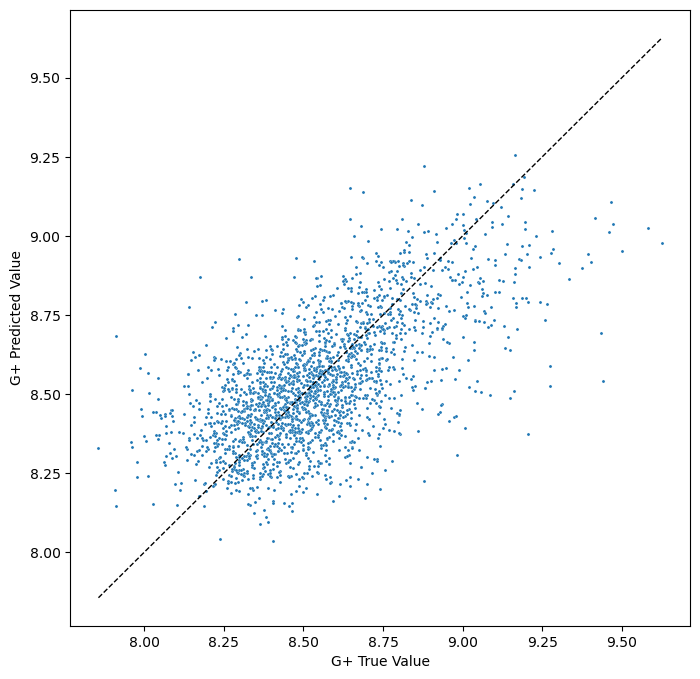

Pearson correlation for Predictions_GFP+: 0.6400611684206623
R^2 score for Predictions_GFP+: 0.38244598514190586


In [9]:
df = pd.read_csv(f'{output_dir}/test_prediction_results.csv')

# Plot for G+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df['True_GFP+'], y=df['Predictions_GFP+'], s=5)

# Add diagonal line
min_val = min(df['Predictions_GFP+'].min(), df['True_GFP+'].min())
max_val = max(df['Predictions_GFP+'].max(), df['True_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.ylabel('G+ Predicted Value')
plt.xlabel('G+ True Value')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for GFP')

# Show the plot
plt.show()

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# Calculate Pearson correlation for Predictions_GFP
correlation_gfp_minus, _ = pearsonr(df['True_GFP+'], df['Predictions_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_minus}")

r2_gfp_minus = r2_score(df['True_GFP+'], df['Predictions_GFP+'])
print(f"R^2 score for Predictions_GFP+: {r2_gfp_minus}")

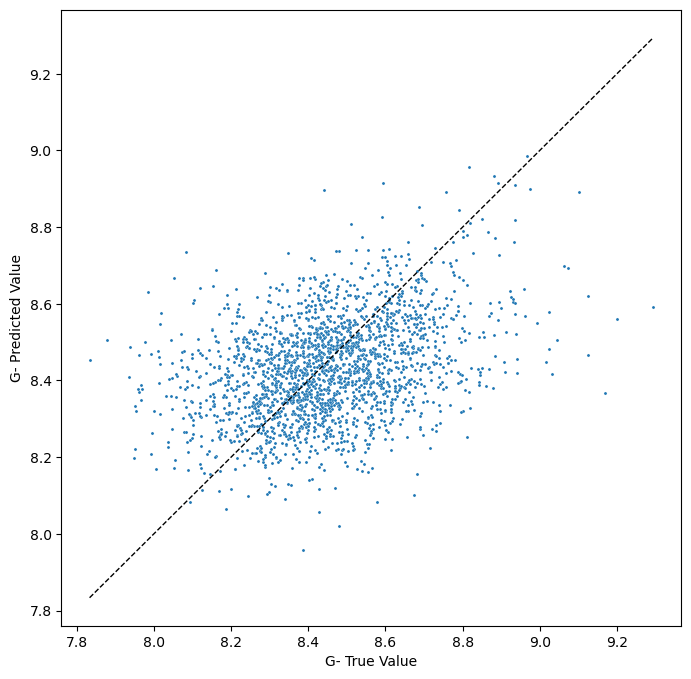

Pearson correlation for Predictions_GFP-: 0.3722501178201392
R^2 score for Predictions_GFP-: 0.028944012596696322


In [10]:
# Plot for G-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df['True_GFP-'], y=df['Predictions_GFP-'], s=5)

# Add diagonal line
min_val = min(df['Predictions_GFP-'].min(), df['True_GFP-'].min())
max_val = max(df['Predictions_GFP-'].max(), df['True_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.ylabel('G- Predicted Value')
plt.xlabel('G- True Value')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for GFP')

# Show the plot
plt.show()

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# Calculate Pearson correlation for Predictions_GFP
correlation_gfp_minus, _ = pearsonr(df['True_GFP-'], df['Predictions_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")

r2_gfp_minus = r2_score(df['True_GFP-'], df['Predictions_GFP-'])
print(f"R^2 score for Predictions_GFP-: {r2_gfp_minus}")

#### Interpret

In [4]:
def get_explainn_unit_activations(data_loader, model, device):
    """
    Function to scan input sequences by ExplaiNN model convolutional filters and compute the convolutional units outputs
    (activations)
    :param data_loader: torch DataLoader, the sequence dataset
    :param model: ExplaiNN model
    :param device: current available device ('cuda:0' or 'cpu')
    :return: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset; U - number of units;
    S - size of the activation map
    """
    bar_format = "{percentage:3.0f}%|{bar:20}{r_bar}"

    running_activations = []
    tqdm_kwargs = {"bar_format": bar_format, "total": len(data_loader)}

    with torch.no_grad():
        for seq, lbl in tqdm(data_loader, **tqdm_kwargs):
            seq = seq.to(device)
            seq = seq.repeat(1, model._options["num_cnns"], 1)
            act = model.linears[:3](seq)

            running_activations.extend(act.cpu().numpy().astype(np.half))

    return np.array(running_activations)

def get_explainn_unit_cnn_outputs(data_loader, model, device):
    """
    Function to scan input sequences by ExplaiNN model convolutional filters and compute the convolutional units outputs
    (activations)
    :param data_loader: torch DataLoader, the sequence dataset
    :param model: ExplaiNN model
    :param device: current available device ('cuda:0' or 'cpu')
    :return: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset; U - number of units;
    S - size of the activation map
    """
    bar_format = "{percentage:3.0f}%|{bar:20}{r_bar}"

    running_cnn_outputs = []
    running_cnn_outputs_test = []
    tqdm_kwargs = {"bar_format": bar_format, "total": len(data_loader)}

    with torch.no_grad():
        for seq, lbl in tqdm(data_loader, **tqdm_kwargs):
            seq = seq.to(device)
            seq = seq.repeat(1, model._options["num_cnns"], 1)
            cnn_output = model.linears[:14](seq)
            cnn_output_test = model.linears(seq)

            running_cnn_outputs.extend(cnn_output.cpu().numpy().astype(np.half))
            running_cnn_outputs_test.extend(cnn_output_test.cpu().numpy().astype(np.half))


    return np.array(running_cnn_outputs), np.array(running_cnn_outputs_test)

def get_explainn_predictions(data_loader, model, device, isSigmoid=False):
    """
    Function to get predictions and true labels for all sequences in the given data loader
    :param data_loader: torch DataLoader, data loader with the sequences of interest
    :param model: ExplaiNN model
    :param device: current available device ('cuda:0' or 'cpu')
    :param isSigmoid: boolean, True if the model output is binary
    :return: tuple of numpy.arrays, model predictions, true labels, and IDs
    """

    running_outputs = []
    running_labels = []
    id_list = []

    with torch.no_grad():
        for seq, lbl, ids in data_loader:
            seq = seq.to(device)
            out = model(seq)
            if isSigmoid:
                sigmoid = nn.Sigmoid()
                out = sigmoid(out.detach().cpu())
            else:
                out = out.detach().cpu()
            running_outputs.extend(out.numpy())
            running_labels.extend(lbl.numpy())
            id_list.extend(ids)  # Flatten the ID list by extending, not appending

    running_labels = np.array(running_labels)
    running_outputs = np.array(running_outputs)
    id_list = np.array(id_list)  # Convert to a NumPy array of strings

    return running_outputs, running_labels, id_list

def get_activation_info(weight_folder, data_loader, num_cnns, name, upper_bound = 0.1, output_folder = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model without moving it to the device yet
    explainn = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=2,
                        filter_size=19, num_fc=2, pool_size=7, pool_stride=7,
                        drop_out=0.3, weight_path=None)  # Training
    
    file_list = glob.glob(f'{weight_folder}/best_pearson*.pth')
    weight_file = file_list[0]
    print(f"Extracting from {weight_file}")
    state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device
    # Load the modified state_dict into the model
    explainn.load_state_dict(state_dict)

    # Move the model to the appropriate device after loading the weights
    explainn.to(device)
    explainn.eval()
    print('Getting Prediction --')
    predictions, labels, ids = get_explainn_predictions(data_loader, explainn, device, isSigmoid=False)
    print("Prediction Get!")
    residuals = np.abs(labels - predictions)
    mask = (residuals <= upper_bound).all(axis=1)
    data_inp = []
    data_out = []

    # Iterate over the DataLoader
    for batch_features, batch_labels, id in data_loader:
        data_inp.append(batch_features)
        data_out.append(batch_labels)
    # Concatenate all the batches into single tensors
    data_inp = torch.cat(data_inp, dim=0)
    data_out = torch.cat(data_out, dim=0)

    # Use the mask to filter the predictions and labels
    print(f'Total number of input samples: {len(data_inp)}')
    data_inp = data_inp[mask]
    data_out = data_out[mask]
    ids = ids[mask]
    print(f'Number of input samples with high confident prediction: {len(data_inp)}')
    print(f'Length of ids array {len(ids)}')

    # Create a TensorDataset with `data_inp`, `data_out`, and `ids_tensor`
    dataset = torch.utils.data.TensorDataset(data_inp, data_out)

    # Create a DataLoader from the dataset
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=best_batch,
                                            shuffle=False)
    activations = get_explainn_unit_activations(data_loader, explainn, device)
    print(f'activation has shape {activations.shape}')
    cnn_outputs = get_explainn_unit_cnn_outputs(data_loader, explainn, device)
    print(f'CNN output has shape {cnn_outputs.shape}')


    ##### Create data frames ######
    # Assuming `activations`, `ids`, `filter_size`, and `sequences` are already defined
    n_filters = activations.shape[1]
    n_samples = activations.shape[0]
    bar_format = "{l_bar}{bar:10}{r_bar}{bar:-10b}"

    # Compute activation threshold
    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))

    # Data storage
    activation_data = []

    # Loop through filters and samples
    tqdm_kwargs = {"bar_format": bar_format, "total": n_filters}
    for i in tqdm(range(n_filters), **tqdm_kwargs):
        for j in range(n_samples):
            # Find all indices where the filter is activated
            indices = np.where(activations[j, i, :] > activation_threshold[i])[0]
            for start in indices:
                end = start + 19
                activation_value = activations[j, i, start]
                activation_data.append([ids[j], i + 1, start, end, activation_value])

    # Create a pandas DataFrame
    activation_df = pd.DataFrame(
        activation_data, columns=["sequence_id", "filter", "start", "end", "activation_value"]
    )

    # Display or save the DataFrame

    weights = explainn.final.weight.detach().cpu().numpy()
    # Assuming `weights` is a NumPy array of shape (2, n_filters)
    # Convert weights to a DataFrame for easy indexing
    weights_df = pd.DataFrame(weights.T, columns=["weight_G+", "weight_G-"])

    # Merge weights with `activation_df` based on the filter column
    activation_df["weight_G+"] = activation_df["filter"].map(weights_df["weight_G+"].to_dict())
    activation_df["weight_G-"] = activation_df["filter"].map(weights_df["weight_G-"].to_dict())

    # Calculate importance scores
    activation_df["importance_score_G+"] = activation_df["activation_value"] * activation_df["weight_G+"]
    activation_df["importance_score_G-"] = activation_df["activation_value"] * activation_df["weight_G-"]

    # Drop intermediate weight columns if not needed
    activation_df.drop(columns=["weight_G+", "weight_G-"], inplace=True)
    if output_dir != None:
        if not os.path.exists(output_folder):
            # Create the folder
            os.mkdir(output_folder)
        activation_df.to_csv(f"{output_folder}/{name}_activations_info.csv")
        weights_df.to_csv(f"{output_folder}/{name}_weights.csv")
        np.save(f"{output_folder}/{name}_cnn_outputs.npy", cnn_outputs)
        np.save(f'{output_folder}/{name}_seq_names.npy', ids)
        with gzip.open(f"{output_folder}/{name}_activations.pkl.gz", "wb") as f:
            pickle.dump(activations, f)
    return activation_df

def test_get_activation(weight_folder, data_loader, num_cnns, name, upper_bound = 0.1, output_folder = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model without moving it to the device yet
    explainn = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=2,
                        filter_size=19, num_fc=2, pool_size=7, pool_stride=7,
                        drop_out=0.3, weight_path=None)  # Training
    
    file_list = glob.glob(f'{weight_folder}/best_pearson*.pth')
    weight_file = file_list[0]
    print(f"Extracting from {weight_file}")
    state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device
    # Load the modified state_dict into the model
    explainn.load_state_dict(state_dict)

    # Move the model to the appropriate device after loading the weights
    explainn.to(device)
    explainn.eval()
    print('Getting Prediction --')
    predictions, labels, ids = get_explainn_predictions(data_loader, explainn, device, isSigmoid=False)
    print("Prediction Get!")
    residuals = np.abs(labels - predictions)
    mask = (residuals <= upper_bound).all(axis=1)
    data_inp = []
    data_out = []

    # Iterate over the DataLoader
    for batch_features, batch_labels, id in data_loader:
        data_inp.append(batch_features)
        data_out.append(batch_labels)
    # Concatenate all the batches into single tensors
    data_inp = torch.cat(data_inp, dim=0)
    data_out = torch.cat(data_out, dim=0)

    # Use the mask to filter the predictions and labels
    print(f'Total number of input samples: {len(data_inp)}')
    data_inp = data_inp[mask]
    data_out = data_out[mask]
    ids = ids[mask]
    print(f'Number of input samples with high confident prediction: {len(data_inp)}')
    print(f'Length of ids array {len(ids)}')

    # Create a TensorDataset with `data_inp`, `data_out`, and `ids_tensor`
    dataset = torch.utils.data.TensorDataset(data_inp, data_out)

    # Create a DataLoader from the dataset
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=best_batch,
                                            shuffle=False)
    cnn_outputs, cnn_outputs2 = get_explainn_unit_cnn_outputs(data_loader, explainn, device)

    print(f'CNN output has shape {cnn_outputs.shape}')
    weights = explainn.final.weight.detach().cpu().numpy()
    weights_df = pd.DataFrame(weights.T, columns=["weight_G+", "weight_G-"])
    bias = explainn.final.bias.detach().cpu().numpy()

    return cnn_outputs, cnn_outputs2,weights_df, predictions, ids, bias

#### Test get cnn_outputs

In [5]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

num_cnns = 20
rep = 5

temp_df = params[params['num_cnns'] == num_cnns]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


weight_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'
output_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_{num_cnns}CNN'

cnn1, cnn2, weights_df,predictions, ids, bias = test_get_activation(weight_folder = weight_folder, data_loader=test_loader, num_cnns=num_cnns,name = 'test', upper_bound=0.1, output_folder=output_folder)



cnn: 20
lr: 0.0005    drop_out: 0.3
batch: 96    seed: 350
Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5/best_pearson_model_epoch_171.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2146
Number of input samples with high confident prediction: 437
Length of ids array 437


100%|████████████████████| 5/5 [00:00<00:00, 14.12it/s]

CNN output has shape (437, 20)


In [7]:
print(cnn1.shape)
print(weights_df.shape)
print(bias.shape)

(437, 20)
(20, 2)
(2,)


In [9]:
weights_array = weights_df.values

# Perform matrix multiplication
result = np.dot(cnn1, weights_array)  
result += bias
print(result[:5,:])
print(ids[:5])

[[8.49358  8.497086]
 [9.038217 8.383559]
 [8.599785 8.496756]
 [8.830103 8.375967]
 [8.362015 8.399281]]
['07_24_22' '00_10_15' '09_04_07' '08_09_15' '19_00_19']


In [37]:
cnn3 = np.load('/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN/test_cnn_outputs.npy')
test_predictions = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5/test_prediction_results.csv")
subset_test_predictions = test_predictions[test_predictions['Fragment_ID'].isin(ids)]
subset_test_predictions

,Fragment_ID,Predictions_GFP+,True_GFP+,Predictions_GFP-,True_GFP-
7,07_24_22,8.493248,8.589355,8.496706,8.438820
14,00_10_15,9.037589,9.070335,8.383011,8.355645
16,09_04_07,8.599781,8.549025,8.496788,8.574525
17,08_09_15,8.829840,8.737590,8.375617,8.287850
21,19_00_19,8.362074,8.338395,8.399318,8.373945
...,...,...,...,...,...
2095,10_15_23,9.156388,9.092855,8.473915,8.485005
2096,14_05_06,8.265622,8.302275,8.205559,8.272540
2101,22_03_11,8.638571,8.560655,8.749562,8.722985
2138,07_03_04,8.451041,8.528065,8.403642,8.378525


#### Below is actual code

In [106]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

num_cnns = 20
rep = 5

temp_df = params[params['num_cnns'] == num_cnns]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


cnn: 20
lr: 0.0005    drop_out: 0.3
batch: 96    seed: 350


In [ ]:
weight_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'
output_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_{num_cnns}CNN'

activation_df = get_activation_info(weight_folder = weight_folder, data_loader=test_loader, num_cnns=num_cnns,name = 'test', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=train_loader, num_cnns=num_cnns,name = 'train', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=val_loader, num_cnns=num_cnns,name = 'validation', upper_bound=0.1, output_folder=output_folder)

Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep6/best_pearson_model_epoch_81.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2146
Number of input samples with high confident prediction: 351
Length of ids array 351


  0%|                    | 0/4 [00:00<?, ?it/s]

100%|████████████████████| 4/4 [00:00<00:00, 192.51it/s]


activation has shape (351, 20, 590)


100%|████████████████████| 4/4 [00:00<00:00, 471.73it/s]


CNN output has shape (351, 20)


100%|██████████| 20/20 [00:00<00:00, 492.10it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep6/best_pearson_model_epoch_81.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 10010
Number of input samples with high confident prediction: 2765
Length of ids array 2765


100%|████████████████████| 29/29 [00:00<00:00, 222.49it/s]


activation has shape (2765, 20, 590)


100%|████████████████████| 29/29 [00:00<00:00, 843.75it/s]


CNN output has shape (2765, 20)


100%|██████████| 20/20 [00:00<00:00, 51.96it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep6/best_pearson_model_epoch_81.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2145
Number of input samples with high confident prediction: 399
Length of ids array 399


100%|████████████████████| 5/5 [00:00<00:00, 231.44it/s]


activation has shape (399, 20, 590)


100%|████████████████████| 5/5 [00:00<00:00, 536.08it/s]


CNN output has shape (399, 20)


100%|██████████| 20/20 [00:00<00:00, 475.09it/s]


In [9]:
weight_folder = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/60NN_Rep5'
output_folder = '/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_60CNN'

activation_df = get_activation_info(weight_folder = weight_folder, data_loader=test_loader, num_cnns=60,name = 'test', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=train_loader, num_cnns=60,name = 'train', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=val_loader, num_cnns=60,name = 'validation', upper_bound=0.1, output_folder=output_folder)

Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/60NN_Rep5/best_pearson_model_epoch_112.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2146
Number of input samples with high confident prediction: 438
Length of ids array 438


100%|████████████████████| 5/5 [00:00<00:00,  9.40it/s]


activation has shape (438, 60, 590)


100%|██████████| 60/60 [00:00<00:00, 448.39it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/60NN_Rep5/best_pearson_model_epoch_112.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 10010
Number of input samples with high confident prediction: 3902
Length of ids array 3902


100%|████████████████████| 41/41 [00:04<00:00,  8.37it/s]


activation has shape (3902, 60, 590)


100%|██████████| 60/60 [00:01<00:00, 43.94it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/60NN_Rep5/best_pearson_model_epoch_112.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2145
Number of input samples with high confident prediction: 437
Length of ids array 437


100%|████████████████████| 5/5 [00:00<00:00,  9.52it/s]


activation has shape (437, 60, 590)


100%|██████████| 60/60 [00:00<00:00, 441.00it/s]


In [7]:
weight_folder = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5'
output_folder = '/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN'

activation_df = get_activation_info(weight_folder = weight_folder, data_loader=test_loader, num_cnns=20,name = 'test', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=train_loader, num_cnns=20,name = 'train', upper_bound=0.1, output_folder=output_folder)
activation_df = get_activation_info(weight_folder = weight_folder, data_loader=val_loader, num_cnns=20,name = 'validation', upper_bound=0.1, output_folder=output_folder)

Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5/best_pearson_model_epoch_171.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2146
Number of input samples with high confident prediction: 437
Length of ids array 437


100%|████████████████████| 5/5 [00:00<00:00,  9.97it/s]


activation has shape (437, 20, 590)


100%|██████████| 20/20 [00:00<00:00, 368.98it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5/best_pearson_model_epoch_171.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 10010
Number of input samples with high confident prediction: 3589
Length of ids array 3589


100%|████████████████████| 38/38 [00:04<00:00,  9.07it/s]


activation has shape (3589, 20, 590)


100%|██████████| 20/20 [00:00<00:00, 32.67it/s]


Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep5/best_pearson_model_epoch_171.pth
Getting Prediction --
Prediction Get!
Total number of input samples: 2145
Number of input samples with high confident prediction: 440
Length of ids array 440


100%|████████████████████| 5/5 [00:00<00:00,  9.53it/s]


activation has shape (440, 20, 590)


100%|██████████| 20/20 [00:00<00:00, 303.68it/s]


## Train DeepSTARR with merged data

In [5]:
for i in range(1,6):
    output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DeepSTARR_Rep{i}_75NN'

    params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR/DeepSTARR_G+G-_Metrics.csv')

    temp_df = params

    group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
    best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
    # Extract the learning rate, dropout rate, and batch number for this best group
    best_lr = best_group['lr']
    best_dropout = best_group['drop_out']
    best_batch = best_group['batch']
    # Filter the original DataFrame to keep only the rows matching the best group
    best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                            (temp_df['drop_out'] == best_dropout) & 
                            (temp_df['batch'] == best_batch)]

    # Find the row with the highest 'pearson_corr_p' within this filtered group
    best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

    # Extract the seed with the highest 'pearson_corr_p' in the best group
    best_seed = int(best_seed_row['seed'])
    best_batch = int(best_batch)

    target_labels = ["GFP+","GFP-"]
    feature_list = ["G+","G-"]

    print(f'lr: {best_lr}    drop_out: {best_dropout}')
    print(f'batch: {best_batch}    seed: {best_seed}')

    #seed = best_seed
    seed = best_seed
    batch = best_batch
    learning_rate= best_lr



    input_model = DeepSTARR(num_classes = 2)
    #input_model = ConvNetDeep(num_classes=2, drop_out=dropout)
    #input_model = DanQ(input_length = 608, num_classes = 2)

    _, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                                num_epochs=200, 
                                                                                            batch_size=batch, learning_rate=learning_rate, 
                                                                                            criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                            seed = seed, save_model= True, dir_path=output_dir)

    file_list = glob.glob(f'{output_dir}/best_pearson*.pth')

    for weight_file in file_list:
        print(f"Evaluating model with weights from: {weight_file}")
        _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
        _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
        df_predictions_d = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)

lr: 0.005    drop_out: 0.3
batch: 96    seed: 41
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 73.5122
Epoch 1/200 -- Train Loss: 8.7980 , Validation Loss: 1.8425
------------------------Evaluation------------------------
Label 1: MSE=1.8874, RMSE=1.3738, MAE=1.2423, R^2=-31.1576, Pearson=0.0932, Spearman=0.1002
Label 2: MSE=1.8005, RMSE=1.3418, MAE=1.2173, R^2=-47.9143, Pearson=0.0286, Spearman=0.0303
Overall (Flattened): MSE=1.8440, RMSE=1.3579, MAE=1.2298, R^2=-36.0878, Pearson=0.0738, Spearman=0.0725
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 1.1324
Epoch 2/200 -- Train Loss: 1.0910 , Validation Loss: 1.6860
------------------------Evaluation------------------------
Label 1: MSE=1.7429, RMSE=1.3202, MAE=1.2299, R^2=-28.6963, Pearson=0.1459, Spearman=0.1440
Label 2: MSE=1.6339, RMSE=1.2782, MAE=1.1919, R^2=-43.3872, Pearson=0.0938, Spearman=0.0939
Overall (Flattened): MSE=1.6884, RMSE=1.2994, MAE=1.2109, R^2

In [38]:
file_list = glob.glob(f'{output_dir}/best_pearson*.pth')

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions_d = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)

Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DeepSTARR_Rep5_60NN/best_pearson_model_epoch_93.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DeepSTARR_Rep5_60NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DeepSTARR_Rep5_60NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DeepSTARR_Rep5_60NN/test_prediction_results.csv


In [30]:
print(df_predictions.iloc[:2,:])
print(df_predictions_d.iloc[:2,:])

NameError: name 'df_predictions' is not defined

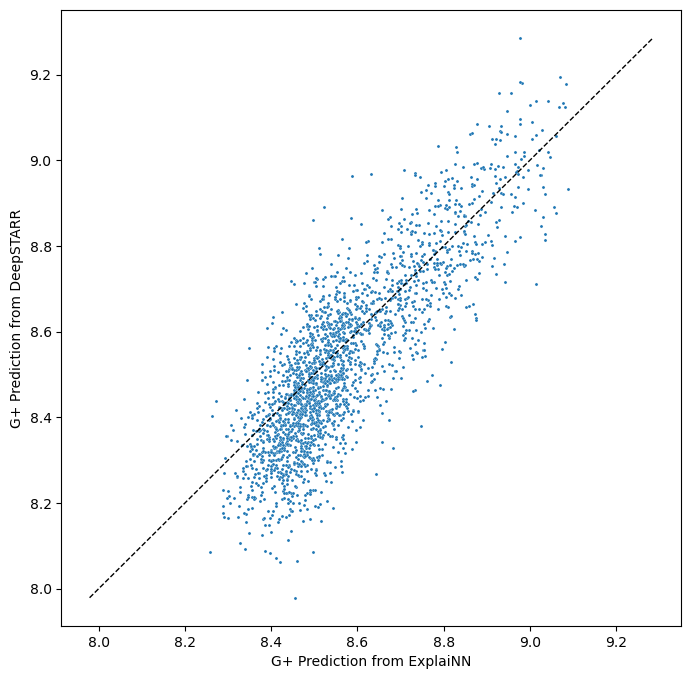

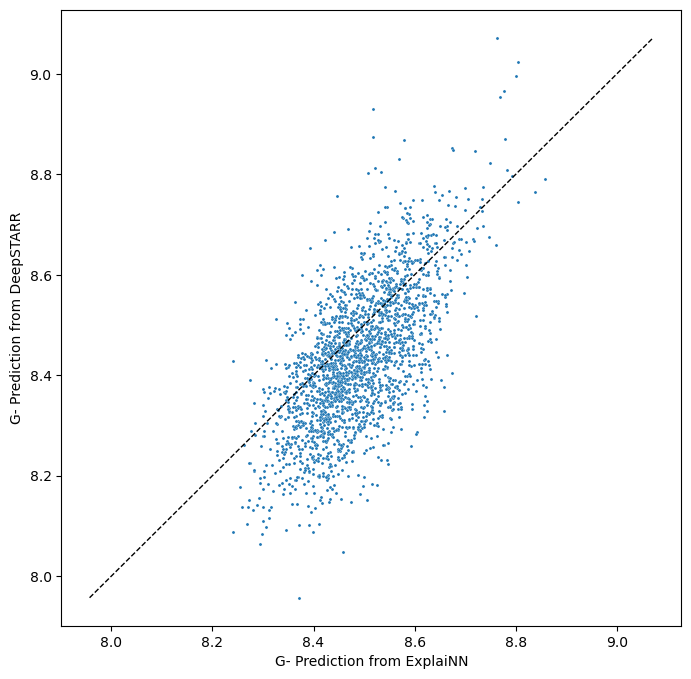

Pearson correlation for Predictions_GFP+: 0.680746836271117
R^2 score for Predictions_GFP+: -0.3510033366198959
Pearson correlation for Predictions_GFP-: 0.47416751440333693
R^2 score for Predictions_GFP-: -2.721989911741594


In [59]:
# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP+'], y=df_predictions['Predictions_GFP+'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP+'].min(), df_predictions['Predictions_GFP+'].min())
max_val = max(df_predictions_d['Predictions_GFP+'].max(), df_predictions['Predictions_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Prediction from ExplaiNN')
plt.ylabel('G+ Prediction from DeepSTARR')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP-'].min(), df_predictions['Predictions_GFP-'].min())
max_val = max(df_predictions_d['Predictions_GFP-'].max(), df_predictions['Predictions_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Prediction from ExplaiNN')
plt.ylabel('G- Prediction from DeepSTARR')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_d['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")
r2_gfp_plus = r2_score(df_predictions_d['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"R^2 score for Predictions_GFP+: {r2_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")
r2_gfp_minus = r2_score(df_predictions_d['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"R^2 score for Predictions_GFP-: {r2_gfp_minus}")


## Train DanQ with Merged Data

In [1]:
for i in range(1,6):
    output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/DanQ_Rep{i}_75NN'

    params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DanQ/DanQ_G+G-_Metrics.csv')

    temp_df = params

    group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
    best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
    # Extract the learning rate, dropout rate, and batch number for this best group
    best_lr = best_group['lr']
    best_dropout = best_group['drop_out']
    best_batch = best_group['batch']
    # Filter the original DataFrame to keep only the rows matching the best group
    best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                            (temp_df['drop_out'] == best_dropout) & 
                            (temp_df['batch'] == best_batch)]

    # Find the row with the highest 'pearson_corr_p' within this filtered group
    best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

    # Extract the seed with the highest 'pearson_corr_p' in the best group
    best_seed = int(best_seed_row['seed'])
    best_batch = int(best_batch)

    target_labels = ["GFP+","GFP-"]
    feature_list = ["G+","G-"]

    print(f'lr: {best_lr}    drop_out: {best_dropout}')
    print(f'batch: {best_batch}    seed: {best_seed}')

    #seed = best_seed
    seed = best_seed
    batch = best_batch
    learning_rate= best_lr

    input_model = DanQ(input_length = 608, num_classes = 2)

    _, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                                num_epochs=200, 
                                                                                            batch_size=batch, learning_rate=learning_rate, 
                                                                                            criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                            seed = seed, save_model= True, dir_path=output_dir)

    file_list = glob.glob(f'{output_dir}/best_pearson*.pth')

    for weight_file in file_list:
        print(f"Evaluating model with weights from: {weight_file}")
        _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
        _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions_danq = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)

NameError: name 'pd' is not defined

In [14]:
#print(df_predictions.iloc[:2,:])
print(df_predictions_danq.iloc[:5,:])

  Fragment_ID  Predictions_GFP+  True_GFP+  Predictions_GFP-  True_GFP-
0    22_23_07          8.505372   8.376870          8.367904   8.474570
1    16_12_19          8.317869   8.013380          8.281385   8.269110
2    07_15_22          8.641733   8.707065          8.363504   8.276675
3    06_12_17          8.618587   8.471095          8.577274   8.189130
4    05_13_18          8.506090   8.390480          8.438982   8.634430


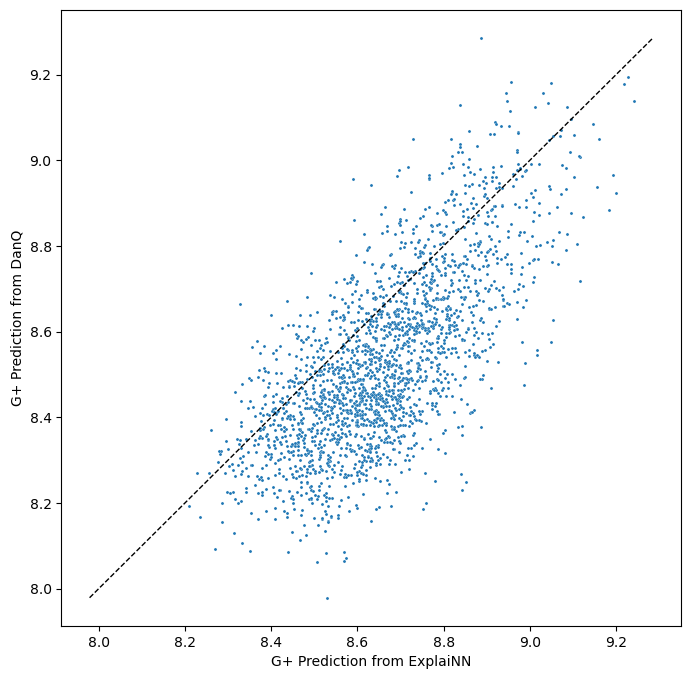

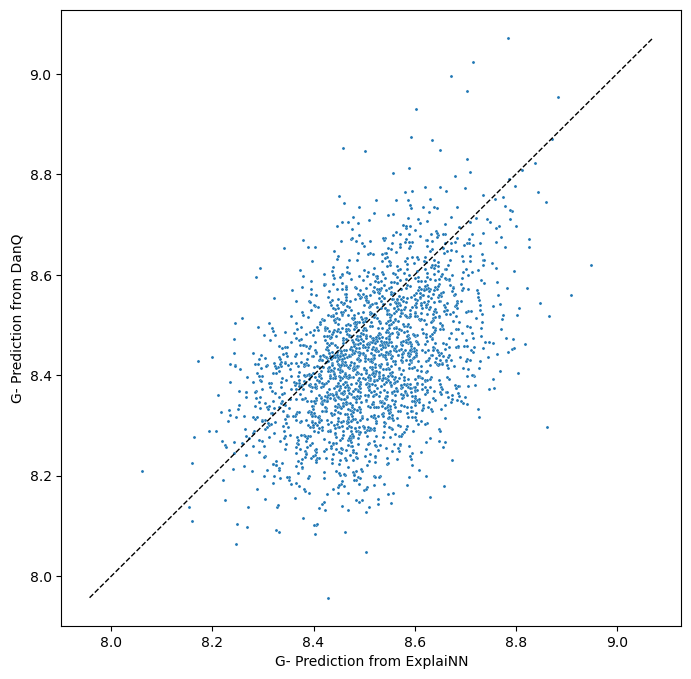

Pearson correlation for Predictions_GFP+: 0.5801464514164942
R^2 score for Predictions_GFP+: -0.8966048233423141
Pearson correlation for Predictions_GFP-: 0.3296313650364322
R^2 score for Predictions_GFP-: -1.8170388687989085


In [ ]:
# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_danq['Predictions_GFP+'], y=df_predictions['Predictions_GFP+'], s=5)

# Add diagonal line
min_val = min(df_predictions_danq['Predictions_GFP+'].min(), df_predictions['Predictions_GFP+'].min())
max_val = max(df_predictions_danq['Predictions_GFP+'].max(), df_predictions['Predictions_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Prediction from ExplaiNN')
plt.ylabel('G+ Prediction from DanQ')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_danq['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=5)

# Add diagonal line
min_val = min(df_predictions_danq['Predictions_GFP-'].min(), df_predictions['Predictions_GFP-'].min())
max_val = max(df_predictions_danq['Predictions_GFP-'].max(), df_predictions['Predictions_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Prediction from ExplaiNN')
plt.ylabel('G- Prediction from DanQ')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_danq['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")
r2_gfp_plus = r2_score(df_predictions_danq['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"R^2 score for Predictions_GFP+: {r2_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_danq['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")
r2_gfp_minus = r2_score(df_predictions_danq['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"R^2 score for Predictions_GFP-: {r2_gfp_minus}")


## Train ConvNetDeep with Merged Data

In [7]:
for i in range(1,6):
    output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Other_Model_G+G-_Merged_Pred/ConvNetDeep_Rep{i}_75NN'

    params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ConvNetDeep/ConvNetDeep_G+G-_Metrics.csv')

    temp_df = params

    group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
    best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
    # Extract the learning rate, dropout rate, and batch number for this best group
    best_lr = best_group['lr']
    best_dropout = best_group['drop_out']
    best_batch = best_group['batch']
    # Filter the original DataFrame to keep only the rows matching the best group
    best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                            (temp_df['drop_out'] == best_dropout) & 
                            (temp_df['batch'] == best_batch)]

    # Find the row with the highest 'pearson_corr_p' within this filtered group
    best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

    # Extract the seed with the highest 'pearson_corr_p' in the best group
    best_seed = int(best_seed_row['seed'])
    best_batch = int(best_batch)

    target_labels = ["GFP+","GFP-"]
    feature_list = ["G+","G-"]

    print(f'lr: {best_lr}    drop_out: {best_dropout}')
    print(f'batch: {best_batch}    seed: {best_seed}')

    #seed = best_seed
    seed = best_seed
    batch = best_batch
    learning_rate= best_lr



    input_model = ConvNetDeep(num_classes=2, drop_out=0.3)

    _, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                                num_epochs=200, 
                                                                                            batch_size=batch, learning_rate=learning_rate, 
                                                                                            criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                            seed = seed, save_model= True, dir_path=output_dir)

    file_list = glob.glob(f'{output_dir}/best_pearson*.pth')

    for weight_file in file_list:
        print(f"Evaluating model with weights from: {weight_file}")
        _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
        _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
        df_predictions_conv = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)

lr: 0.005    drop_out: 0.3
batch: 96    seed: 41
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 72.0294
Epoch 1/200 -- Train Loss: 4.2222 , Validation Loss: 0.2128
------------------------Evaluation------------------------
Label 1: MSE=0.2136, RMSE=0.4622, MAE=0.3757, R^2=-2.6397, Pearson=0.2543, Spearman=0.2665
Label 2: MSE=0.2104, RMSE=0.4587, MAE=0.3790, R^2=-4.7156, Pearson=0.1404, Spearman=0.1451
Overall (Flattened): MSE=0.2120, RMSE=0.4604, MAE=0.3774, R^2=-3.2641, Pearson=0.2258, Spearman=0.2213
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 0.3609
Epoch 2/200 -- Train Loss: 0.3014 , Validation Loss: 0.2543
------------------------Evaluation------------------------
Label 1: MSE=0.2630, RMSE=0.5128, MAE=0.4092, R^2=-3.4808, Pearson=0.2435, Spearman=0.2310
Label 2: MSE=0.2440, RMSE=0.4939, MAE=0.4022, R^2=-5.6275, Pearson=0.1802, Spearman=0.1714
Overall (Flattened): MSE=0.2535, RMSE=0.5035, MAE=0.4057, R^2=-4.0

In [ ]:
print(df_predictions.iloc[:2,:])
print(df_predictions_conv.iloc[:2,:])

In [ ]:
# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_danq['Predictions_GFP+'], y=df_predictions['Predictions_GFP+'], s=5)

# Add diagonal line
min_val = min(df_predictions_danq['Predictions_GFP+'].min(), df_predictions['Predictions_GFP+'].min())
max_val = max(df_predictions_danq['Predictions_GFP+'].max(), df_predictions['Predictions_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Prediction from ExplaiNN')
plt.ylabel('G+ Prediction from DanQ')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_danq['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=5)

# Add diagonal line
min_val = min(df_predictions_danq['Predictions_GFP-'].min(), df_predictions['Predictions_GFP-'].min())
max_val = max(df_predictions_danq['Predictions_GFP-'].max(), df_predictions['Predictions_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Prediction from ExplaiNN')
plt.ylabel('G- Prediction from DanQ')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_danq['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")
r2_gfp_plus = r2_score(df_predictions_danq['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"R^2 score for Predictions_GFP+: {r2_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_danq['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")
r2_gfp_minus = r2_score(df_predictions_danq['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"R^2 score for Predictions_GFP-: {r2_gfp_minus}")


# Train ExplaiNN Predict G+ and G- with Rep1 data

In [3]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep1_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 60]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 60
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep1_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 60
lr: 0.001    drop_out: 0.3
batch: 168    seed: 630
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 69.0956
Epoch 1/200 -- Train Loss: 55.5855 , Validation Loss: 43.3523
------------------------Evaluation------------------------
Label 1: MSE=45.4441, RMSE=6.7412, MAE=6.7338, R^2=-820.4113, Pearson=0.3163, Spearman=0.2843
Label 2: MSE=41.2952, RMSE=6.4261, MAE=6.4185, R^2=-897.6286, Pearson=0.1983, Spearman=0.1907
Overall (Flattened): MSE=43.3696, RMSE=6.5856, MAE=6.5762, R^2=-804.7505, Pearson=0.1587, Spearman=0.1404
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 42.4086
Epoch 2/200 -- Train Loss: 30.6482 , Validation Loss: 19.1209
------------------------Evaluation------------------------
Label 1: MSE=20.4918, RMSE=4.5268, MAE=4.5119, R^2=-369.3936, Pearson=0.2756, Spearman=0.2590
Label 2: MSE=17.7586, RMSE=4.2141, MAE=4.2005, R^2=-385.4456, Pearson=0.1981, Spearman=0.1936
Overall (Flattened): MSE=19.1252, RM

In [4]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/best_pearson_model_epoch_52.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/test_prediction_results.csv


# Train ExplaiNN Predict G+ and G- with Rep1 data

In [6]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep2_Metrics.csv')
#cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep2_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 630
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/59, Loss: 71.3422
Epoch 1/200 -- Train Loss: 70.0175 , Validation Loss: 68.9651
------------------------Evaluation------------------------
Label 1: MSE=70.8416, RMSE=8.4167, MAE=8.4107, R^2=-784.1010, Pearson=0.2273, Spearman=0.2192
Label 2: MSE=67.0992, RMSE=8.1914, MAE=8.1859, R^2=-1190.6455, Pearson=0.0445, Spearman=0.0484
Overall (Flattened): MSE=68.9704, RMSE=8.3048, MAE=8.2983, R^2=-929.6788, Pearson=0.0924, Spearman=0.0944
----------------------------------------------------------
Epoch 2/200, Step 1/59, Loss: 67.8587
Epoch 2/200 -- Train Loss: 66.2504 , Validation Loss: 65.5834
------------------------Evaluation------------------------
Label 1: MSE=67.3261, RMSE=8.2052, MAE=8.1994, R^2=-745.1408, Pearson=0.3303, Spearman=0.3132
Label 2: MSE=63.8571, RMSE=7.9911, MAE=7.9855, R^2=-1133.0688, Pearson=0.0667, Spearman=0.0695
Overall (Flattened): MSE=65.5916,

In [7]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/best_pearson_model_epoch_108.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/test_prediction_results.csv
